In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
# from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow


%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)



### Identy block
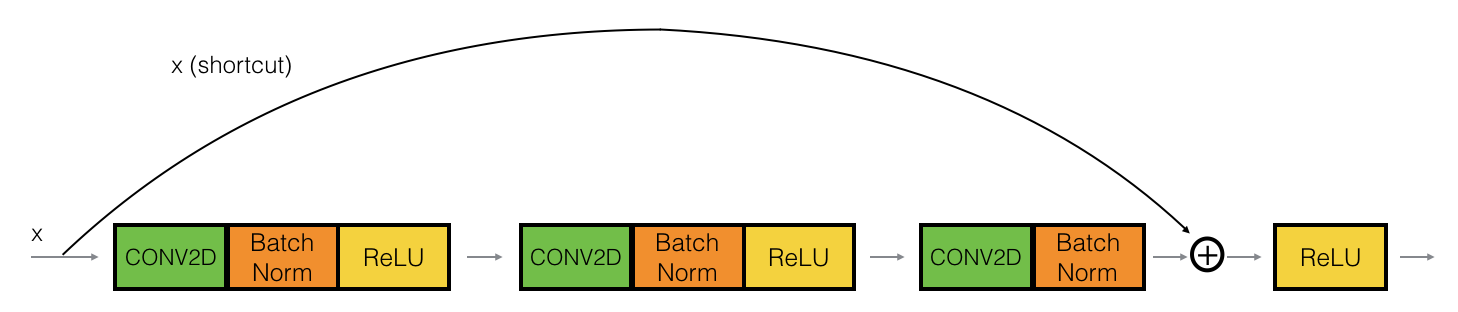
First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` ared()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

In [2]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    F1, F2, F3 = filters
    X_shortcut = X
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    # Second component of main path 
    X = Conv2D(F2, f, strides=(1,1), padding="same", kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X) 
    # Third component of main path
    X = Conv2D(F3, 1,strides=(1,1),padding="valid", kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    return X

### Convalution block 
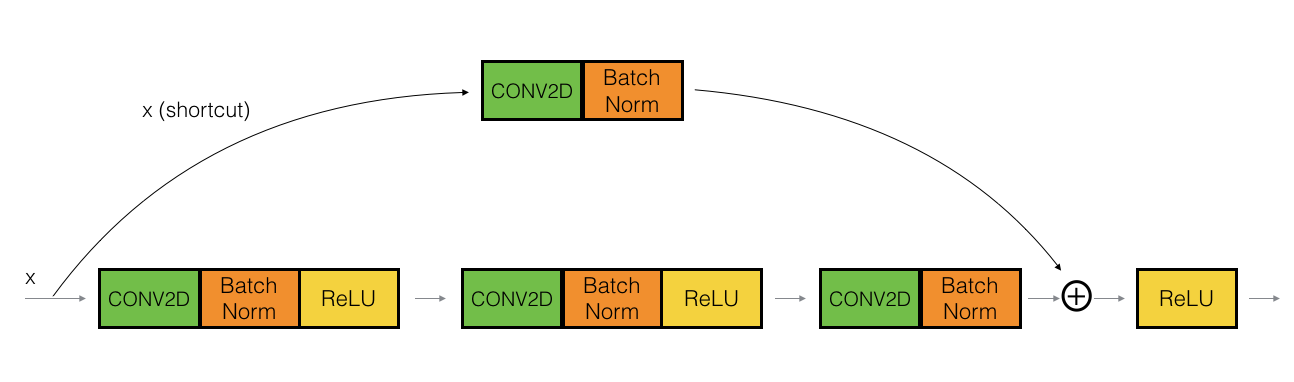

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 
* As for the previous exercise, the additional `initializer` argument is required for grading purposes, and it has been set by default to [glorot_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUnif

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
 orm)

In [3]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X) 
    X = Activation('relu')(X) 

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X) 
    
    # SHORTCUT PATH 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut) 
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut) 

    # Final step: Add shortcut value to main path and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

### Resnet50 using these building blocks
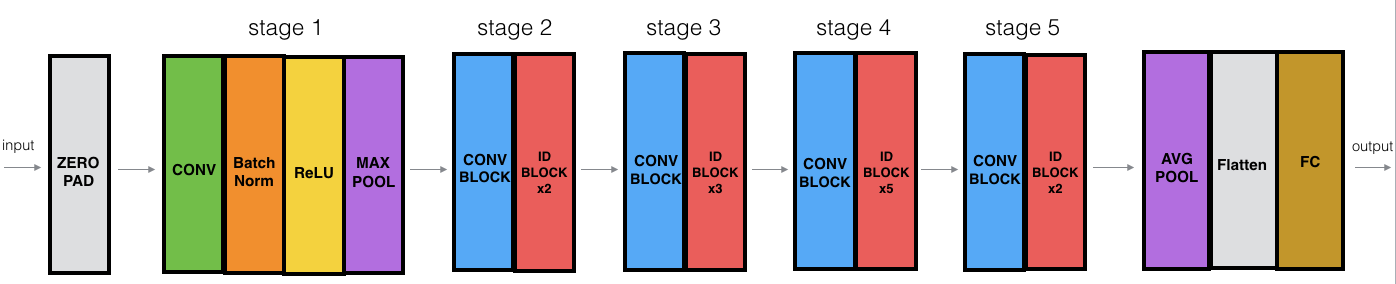
The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.


In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 
    
    ## Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    ## Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2) 
    X = identity_block(X, 3, [512, 512, 2048]) 
    X = identity_block(X, 3, [512, 512, 2048]) 

    ## AVGPOOL
    X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

E:\Anaconda\envs\ML-Learning\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [6]:
# compile time
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    # your train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    # your test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(
        test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [9]:
import h5py
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
model.fit(X_train, Y_train, epochs = 100, batch_size = 16)

Epoch 1/100
68/68 [==============================] - 48s 386ms/step - loss: 1.7079 - accuracy: 0.3722
Epoch 2/100
68/68 [==============================] - 23s 328ms/step - loss: 1.0248 - accuracy: 0.6278
Epoch 3/100
68/68 [==============================] - 23s 339ms/step - loss: 0.5953 - accuracy: 0.7870
Epoch 4/100
68/68 [==============================] - 24s 344ms/step - loss: 0.4306 - accuracy: 0.8426
Epoch 5/100
68/68 [==============================] - 26s 383ms/step - loss: 0.3254 - accuracy: 0.8981
Epoch 6/100
68/68 [==============================] - 27s 400ms/step - loss: 0.2921 - accuracy: 0.9046
Epoch 7/100
68/68 [==============================] - 26s 380ms/step - loss: 0.1831 - accuracy: 0.9380
Epoch 8/100
68/68 [==============================] - 21s 307ms/step - loss: 0.0718 - accuracy: 0.9787
Epoch 9/100
68/68 [==============================] - 26s 392ms/step - loss: 0.1051 - accuracy: 0.9620
Epoch 10/100
68/68 [==============================] - 23s 342ms/step - loss: 0.128

In [11]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 6s 45ms/step - loss: 0.0929 - accuracy: 0.9750
Loss = 0.09289055317640305
Test Accuracy = 0.9750000238418579


Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 30ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.5019074  0.00200243 0.458246   0.0300722  0.00624319 0.00152875]]
Class: 0


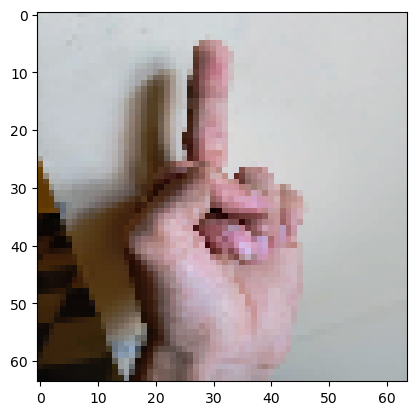

In [14]:
img_path = 'images/3.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x 
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))
